# DSCI 100 Project

Name: Benjamin Lee

Student ID: 26465922

***NOTE: The models may take a few minutes to load so be patient if it does not load instantly***

## Introduction

A research group in Computer Science at UBC is collecting data about how people play video games. They have set up a Minecraft server where they record profiling data on participants as well as game data.

To improve efficiency and focus their efforts, the group must answer a few questions:
1. Can a player's profile (experience, subscribe, gender, age) predict the number of hours played?
2. Can a player's profile (experience, played_hours, gender, age) predict if a player is likely to subscribe to the game-related newsletter (subscribe)?

The provided data sets include the following variables:
### players.csv - 196 observations
- experience (chr) - should be an ordered factor with 5 levels describing the player's experience
- subscribe (lgl) - logical value representing whether or not the player is subscribed
- hashedEmail (chr) - character string used as a unique id for each player
- played_hours (dbl) - the number of hours played in total
- gender (chr) - should be an unordered factor with 6 preset options

### sessions.csv - 1535 observations
- hashedEmail (chr) - character string used as a unique id for each player
- start_time (chr) - should be a date and time of the start of a session
- end_time (chr) - shuold be a date and time of the end of a session
- original_start_time (dbl) - a date and time of the start of a session in computer time (seconds since Jan. 1, 1970)
- original_end_time (dbl) - a date and time of the end of a session in computer time (seconds since Jan. 1, 1970)

## Potential Issues: 
- There are N/A values in both datasets
- The number of unique users in both files do not match
- The number of occurances of certain values in variables are greatly varied
- The data is unscaled
- There are relatively few observations, especially for the players.csv file
    - Outliers could have a much stronger effect than they should
    - Specific players could inflate certain variables disproportionately with long, but few sessions
- Burnout may cause the average playtime to decrease over time
- Away-From-Keyboard (AFK) players could inflate playtime while not actively playing
- Some participants may not take the study seriously, and could contribute useless or harmful data

## Methods and Results

First, we will load the appropriate libraries and data.

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(themis)
library(janitor)
library(rsample)
library(repr)
options(repr.matrix.max.rows = 6)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() mask

In [2]:
players_data_raw <- read_csv("data/players.csv")
sessions_data_raw <- read_csv("data/sessions.csv")
players_data_raw
sessions_data_raw


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


### Preparing Data

Now, we clean the data to put it into a more usable form. 

**players_data steps**
1. Remove N/A rows (very few so it shouldn't cause an issue)
2. Set nominal variables as factors and add levels to experience to order them (Least to greatest: "Beginner", "Amateur", "Regular", "Pro", "Veteran")
3. Rename variables for consistent naming

**sessions_data steps**
1. Remove N/A rows (very few so it shouldn't cause an issue)
2. Set start_time and end_time as POSIXct objects (date objects)
3. Rename variables for consistent naming

In [3]:
players_data <- players_data_raw |>
    drop_na() |>
    select(!name) |>
    mutate(
        experience = as_factor(experience) |>
            fct_relevel("Beginner", "Amateur", "Regular", "Pro", "Veteran"),
        subscribe = as_factor(subscribe),
        gender = as_factor(gender),
        Age = as.integer(Age)
    ) |>
    rename(
        age = Age,
        hashed_email = hashedEmail
    )

sessions_data <- sessions_data_raw |>
    drop_na() |>
    mutate(across(c(start_time, end_time), dmy_hm),
        session_duration = as.duration(end_time - start_time)
    ) |>
    rename(hashed_email = hashedEmail)


In [4]:
players_data


experience,subscribe,hashed_email,played_hours,gender,age
<fct>,<fct>,<chr>,<dbl>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Male,17


*Figure 1*

In [5]:
sessions_data


hashed_email,start_time,end_time,original_start_time,original_end_time,session_duration
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<Duration>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,720s (~12 minutes)
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,780s (~13 minutes)
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,1380s (~23 minutes)
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12,1260s (~21 minutes)
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12,420s (~7 minutes)
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12,1140s (~19 minutes)


*Figure 2*

### Average Hours Played by ...

We will start by graphing the average hours per different variables to get a sense of any trends.

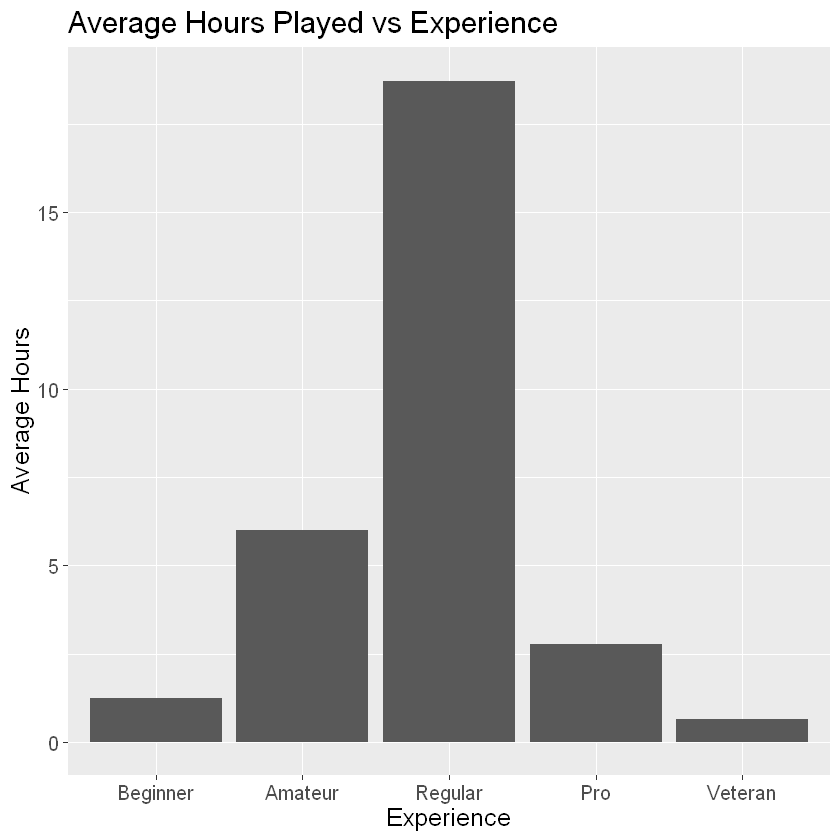

In [6]:
players_data |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))) |>
    group_by(experience) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = experience, y = avg_hrs)) +
    geom_bar(stat = "identity") +
    ggtitle("Average Hours Played vs Experience") +
    xlab("Experience") +
    ylab("Average Hours") +
    theme(text = element_text(size = 15))


*Figure 3*

Regular players seem to have most hours on average while more experienced players, perhaps surprisingly, have fewer hours.

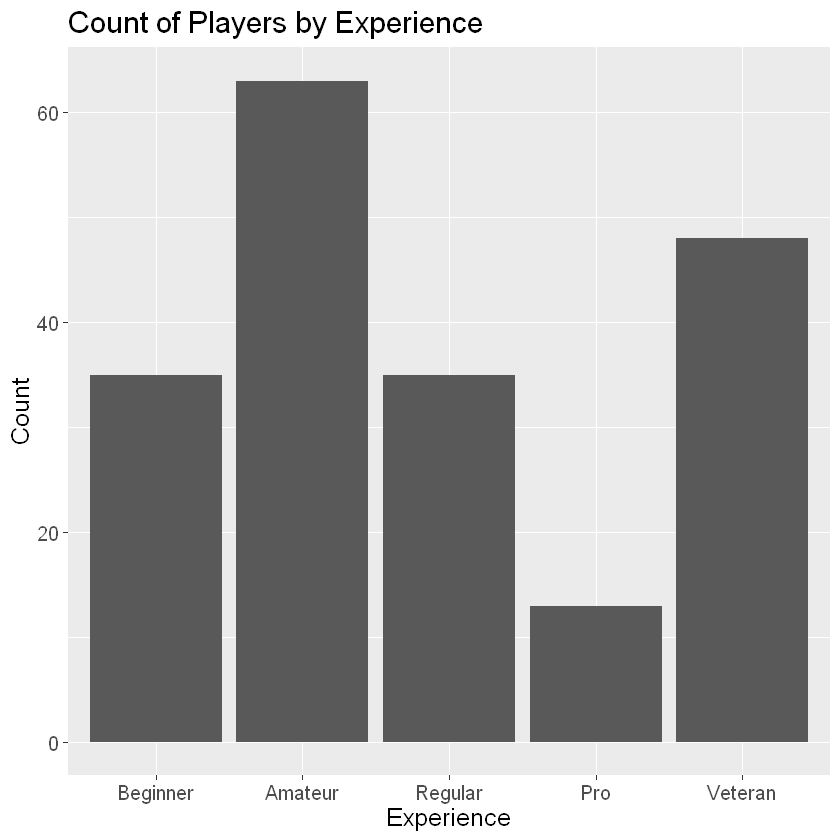

In [32]:
players_data |>
    select(experience) |>
    group_by(experience) |>
    summarize(count = n()) |>
    arrange(desc(count)) |>
    ggplot(aes(x = experience, y = count)) +
    geom_bar(stat = "identity") +
    ggtitle("Count of Players by Experience") +
    xlab("Experience") +
    ylab("Count") +
    theme(text = element_text(size = 15))


*Figure 4*

The experience distribution seems relatively balanced enough to give reliable results.

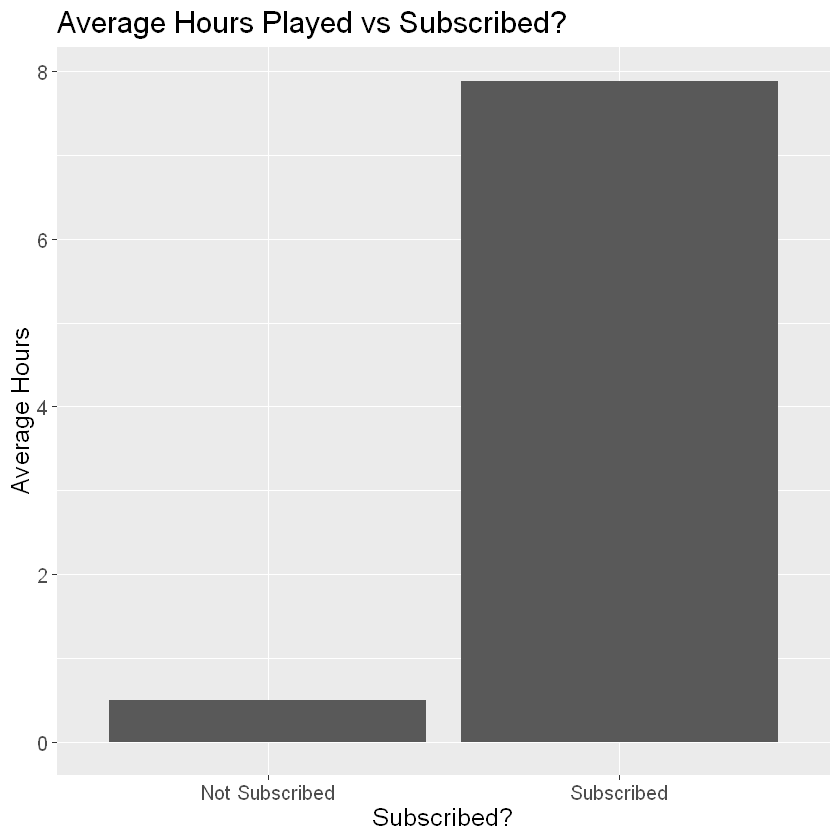

In [8]:
players_data |>
    group_by(subscribe) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = avg_hrs)) +
    geom_bar(stat = "identity") +
    ggtitle("Average Hours Played vs Subscribed?") +
    xlab("Subscribed?") +
    ylab("Average Hours") +
    scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
    theme(text = element_text(size = 15))


*Figure 5*

As expected, subscribed players, on average, have more hours than non-subscribed players.

In [9]:
players_data |>
    select(subscribe) |>
    group_by(subscribe) |>
    summarize(count = n())


subscribe,count
<fct>,<int>
FALSE,52
TRUE,142


*Figure 6*

There are significantly more TRUE values than FALSE so the FALSE values may need to be upscaled later.

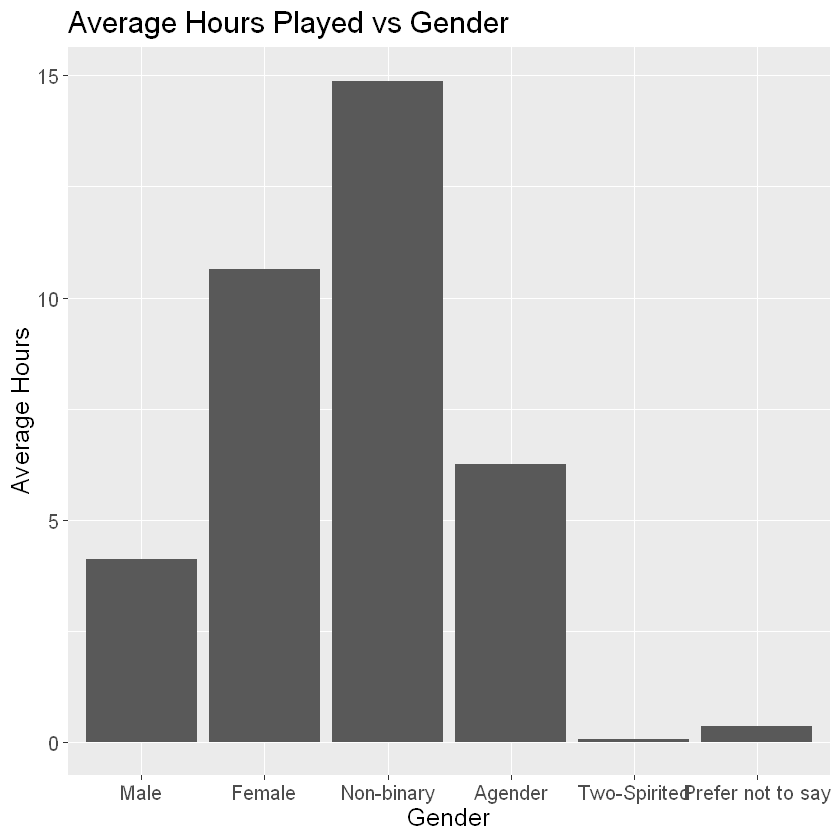

In [10]:
players_data |>
    mutate(gender = factor(gender, levels = c("Male", "Female", "Non-binary", "Agender", "Two-Spirited", "Prefer not to say"))) |>
    group_by(gender) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = gender, y = avg_hrs)) +
    geom_bar(stat = "identity") +
    ggtitle("Average Hours Played vs Gender") +
    xlab("Gender") +
    ylab("Average Hours") +
    theme(text = element_text(size = 15))


*Figure 7*

This visualization shows non-binary and females to have the most average hours compared to other genders. However, it is important to recognize certain genders having a smaller representation in the dataset which could lead to biased results.

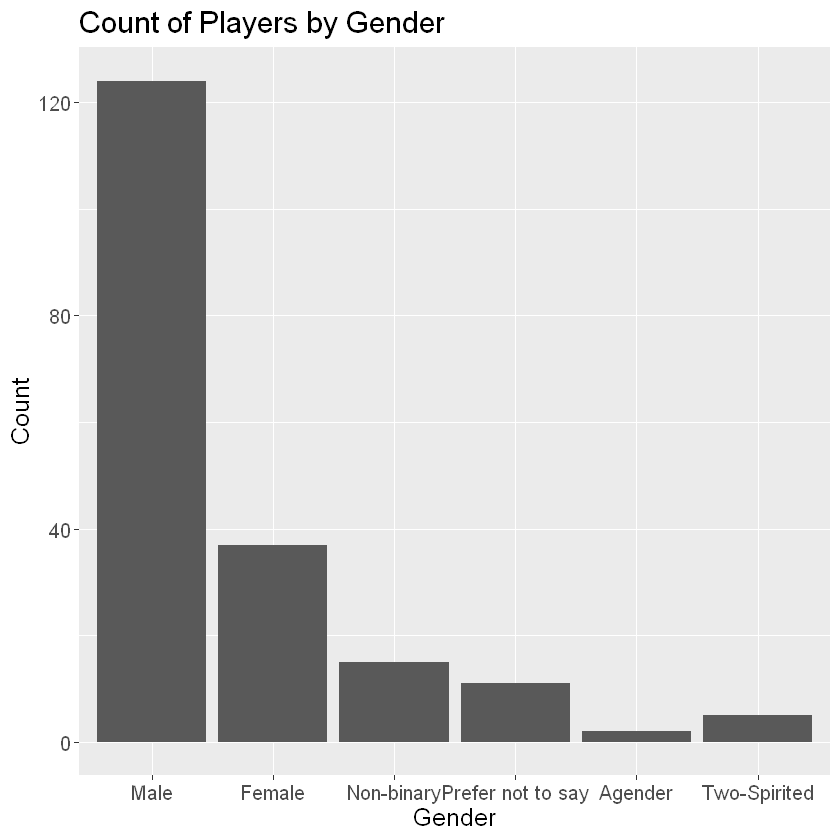

In [31]:
players_data |>
    select(gender) |>
    group_by(gender) |>
    summarize(count = n()) |>
    arrange(desc(count)) |>
    ggplot(aes(x = gender, y = count)) +
    geom_bar(stat = "identity") +
    ggtitle("Count of Players by Gender") +
    xlab("Gender") +
    ylab("Count") +
    theme(text = element_text(size = 15))


*Figure 8*

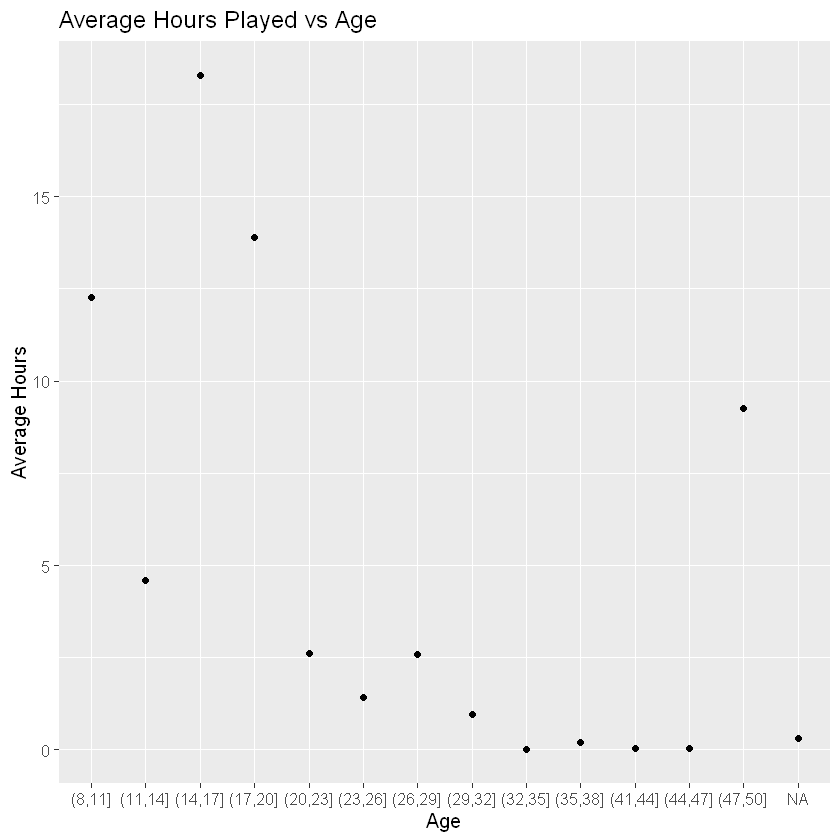

In [12]:
players_data |>
    group_by(age) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ungroup() |>
    mutate(age_bin = cut(age, breaks = seq(floor(min(age)), ceiling(max(age)), by = 3))) |>
    group_by(age_bin) |>
    summarise(avg_hrs = mean(avg_hrs, na.rm = TRUE)) |>
    ggplot(aes(x = age_bin, y = avg_hrs)) +
    geom_point() +
    ggtitle("Average Hours Played vs Age") +
    xlab("Age") +
    ylab("Average Hours") +
    theme(text = element_text(size = 12))


*Figure 9*

The ages of higher average hours seem to fall between the ages of 10 to 25. However, the high variance seems to suggest specific players may have inflated their age group with high playtime. Ages were sorted into bins to help alleviate this.

### Average Session Duration

Average session duration was visualized in comparison to each player's played hours to see if there was any corrolation.

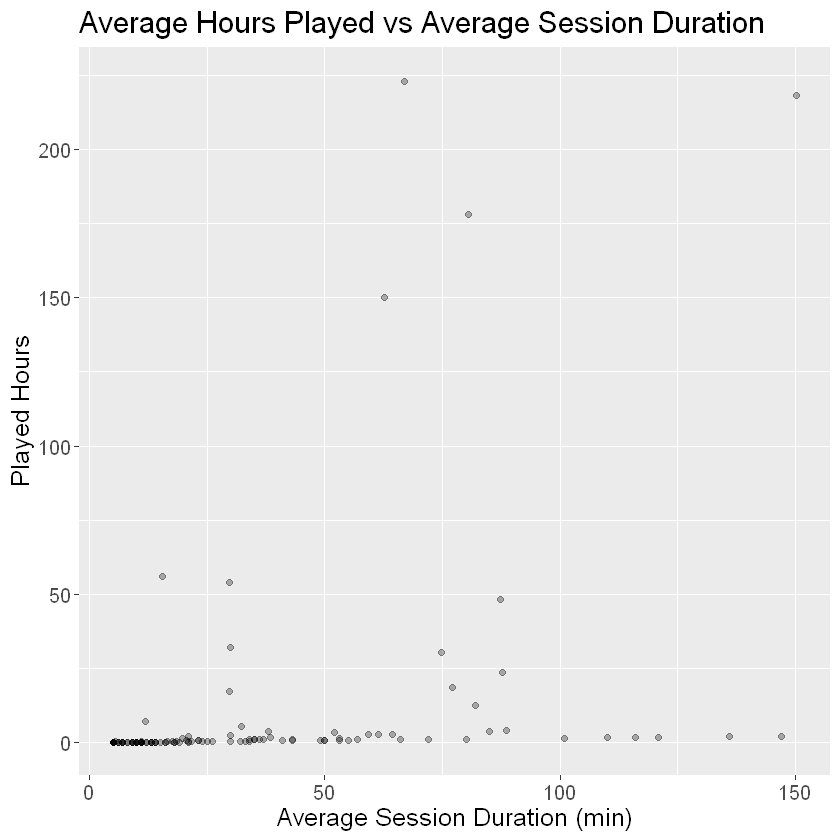

In [13]:
sessions_data |>
    select(hashed_email, session_duration) |>
    group_by(hashed_email) |>
    summarize(avg_session_duration = mean(session_duration) / 60) |>
    inner_join(players_data, by = "hashed_email") |>
    ggplot(aes(x = avg_session_duration, y = played_hours)) +
    geom_point(alpha = 0.3) +
    ggtitle("Average Hours Played vs Average Session Duration") +
    xlab("Average Session Duration (min)") +
    ylab("Played Hours") +
    theme(text = element_text(size = 15))


*Figure 10*

While there may be a weak relationship at high average session durations, the data is more likely to interfere with the model rather than improve it due to it being incredibly skewed to lower values.

In [14]:
players_data |>
    group_by(hashed_email) |>
    summarize(count = n())


hashed_email,count
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1
055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,1
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


*Figure 11*

In [15]:
sessions_data |>
    group_by(hashed_email) |>
    summarize(count = n())


hashed_email,count
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


*Figure 12*

Somehow there are more players with playtime than the number of players that played meaning there may be missing data from the datasets.

## Regression Model for Played Hours

In [16]:
set.seed(60)
player_model_data <- players_data |>
    mutate(experience = as.integer(experience)) |>
    rep_sample_n(size = 194, replace = TRUE, reps = 10)

played_hours_split <- player_model_data |>
    initial_split(prop = 0.75)

played_hours_training <- training(played_hours_split)
played_hours_testing <- testing(played_hours_split)

played_hours_vfold <- vfold_cv(played_hours_training, v = 5, repeats = 5, strata = played_hours)

played_hours_k_values <- tibble(neighbors = seq(from = 1, to = 39, by = 1))

knn_regression_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

played_hours_recipe <- recipe(played_hours ~ experience + subscribe + gender + age, data = played_hours_training) |>
    step_dummy(gender, subscribe) |>
    step_zv() |>
    step_normalize(all_predictors())

played_hours_results <- workflow() |>
    add_recipe(played_hours_recipe) |>
    add_model(knn_regression_spec) |>
    tune_grid(resamples = played_hours_vfold, grid = played_hours_k_values) |>
    collect_metrics() |>
    filter(.metric == "rmse")

In [17]:
played_hours_results_plot <- played_hours_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("RMSE vs Neighbors") +
    xlab("Neighbors") +
    ylab("RMSE") +
    theme(text = element_text(size = 15))

In [18]:
player_model_data


replicate,experience,subscribe,hashed_email,played_hours,gender,age
<int>,<int>,<fct>,<chr>,<dbl>,<fct>,<int>
1,5,TRUE,6b1cdc07fcc1f7ea09509341fd245dd34fdba386f14a493e9107c18604baedc9,0.1,Non-binary,17
1,2,TRUE,dbb20960cd4db4900dde7832e349dae46f7688583c8138b34785d9c7e509b5b9,0.0,Female,26
1,5,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,2,FALSE,8d713786e0bf0371cd928a91d32d1e37b14e14e49744cdebac90885c05c48afa,0.1,Female,32
10,5,TRUE,ba24bebe588a34ac546f8559850c65bc90cd9d51b821581bd6e25cff437a1081,0.1,Female,44
10,2,TRUE,119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,0.7,Female,21


*Figure 13*

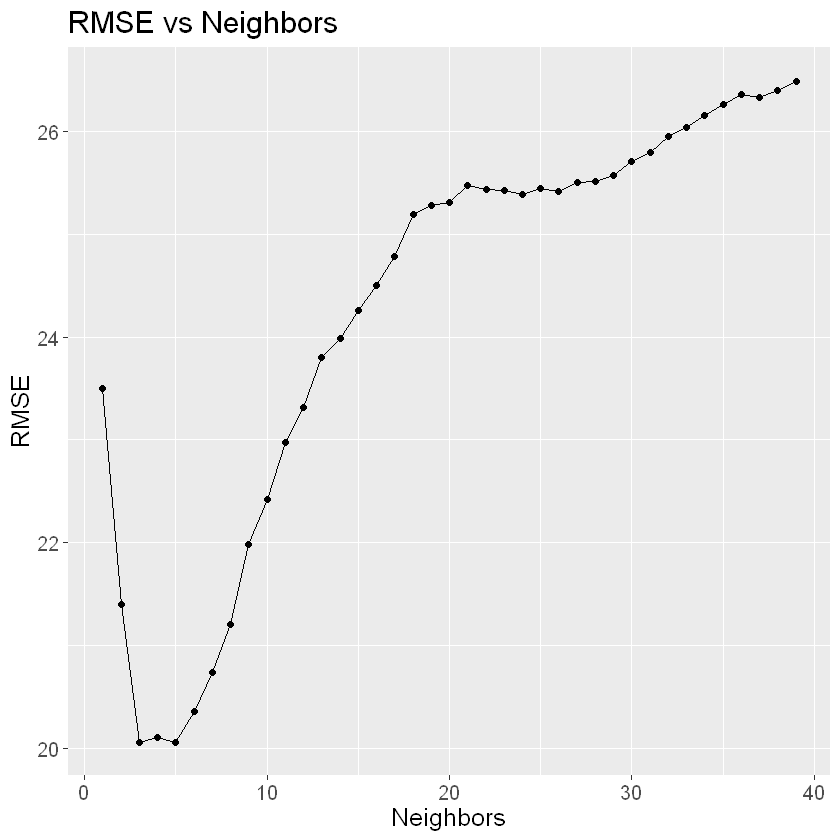

In [19]:
played_hours_results_plot


*Figure 14*

This model uses a KNN regression algorithm to predict the number of played hours for each player given the players' experience, gender, age, and subscription status. KNN is used because we do not know anything about the shape of the data. Regression is used because we are predicting a numerical outcome. The given data is quite small for all the folds and splits it requires. Thus, bootlegging was used to create a more stable model that would give more useful results. 

The dataset has been replicated 10 times and split into 0.75 ratio sets, and vfold repeats has been set to 5 to decrease variance over different seeds and randomness. Gender and subscribe are one-hot encoded to allow them to be passed into the KNN model as unordered factors. The zero-variance factors are then removed and the predictors are scaled.

This produces a best-k-value of 4.

In [20]:
played_hours_best_k <- played_hours_results |>
    arrange(mean) |>
    slice(1) |>
    pull(neighbors)
cat("Best k-value: ", played_hours_best_k)

best_knn_regression_spec <- nearest_neighbor(weight = "rectangular", neighbors = played_hours_best_k) |>
    set_engine("kknn") |>
    set_mode("regression")

played_hours_fit <- workflow() |>
    add_recipe(played_hours_recipe) |>
    add_model(best_knn_regression_spec) |>
    fit(data = played_hours_training)


Best k-value:  5

In [21]:
played_hours_predictions <- predict(played_hours_fit, played_hours_testing) |>
    bind_cols(played_hours_testing)

played_hours_accuracy <- played_hours_predictions |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse") |>
    pull(.estimate)

cat("RMSPE (hours): ", played_hours_accuracy)


RMSPE (hours):  17.81744

The RMSPE of 20 hours is quite large relative to the dataset, so unfortunately it will be difficult to state whether or not the predictors can accurately predict the outcome.

### Subscriber Ratio by ...

With the given data, we can also try to see if we can answer the second question, "Can a player's profile (experience, played_hours, gender, age) predict if a player is likely to subscribe to the game-related newsletter (subscribe)?"

Again, we will graph the subscriber ratio against several of the variables.

`summarise()` has grouped output by 'subscribe'. You can override using the
`.groups` argument.


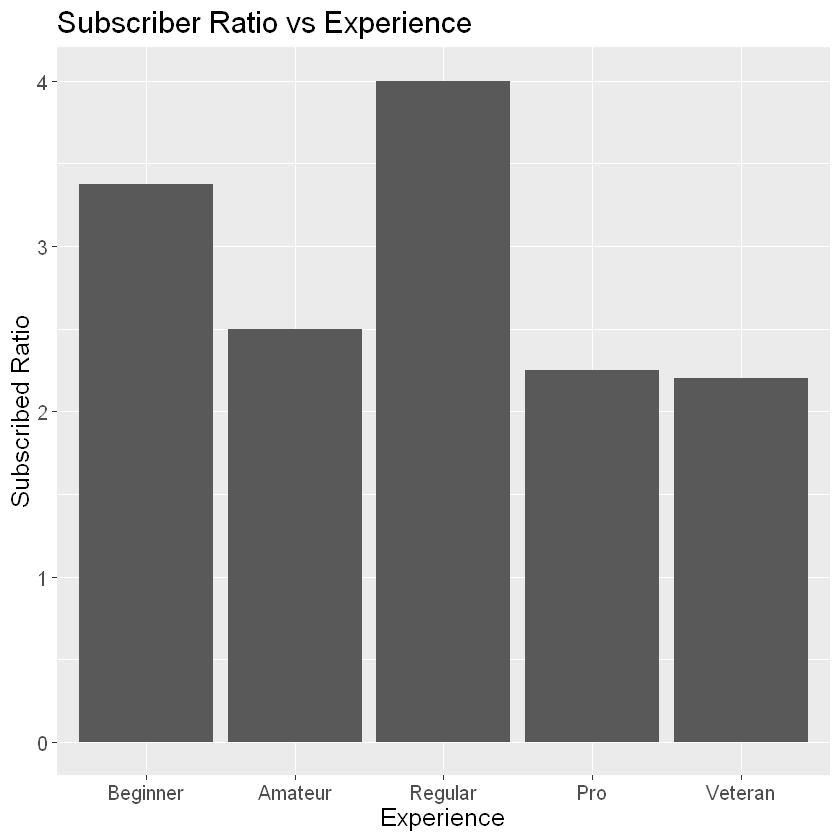

In [22]:
players_data |>
    group_by(subscribe, experience) |>
    summarize(count = n()) |>
    pivot_wider(names_from = subscribe, values_from = count, values_fill = list(count = 0)) |>
    mutate(sub_ratio = `TRUE` / `FALSE`, experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))) |>
    select(experience, sub_ratio) |>
    ggplot(aes(x = experience, y = sub_ratio)) +
    geom_bar(stat = "identity") +
    ggtitle("Subscriber Ratio vs Experience") +
    xlab("Experience") +
    ylab("Subscribed Ratio") +
    scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
    theme(text = element_text(size = 15))


*Figure 15*

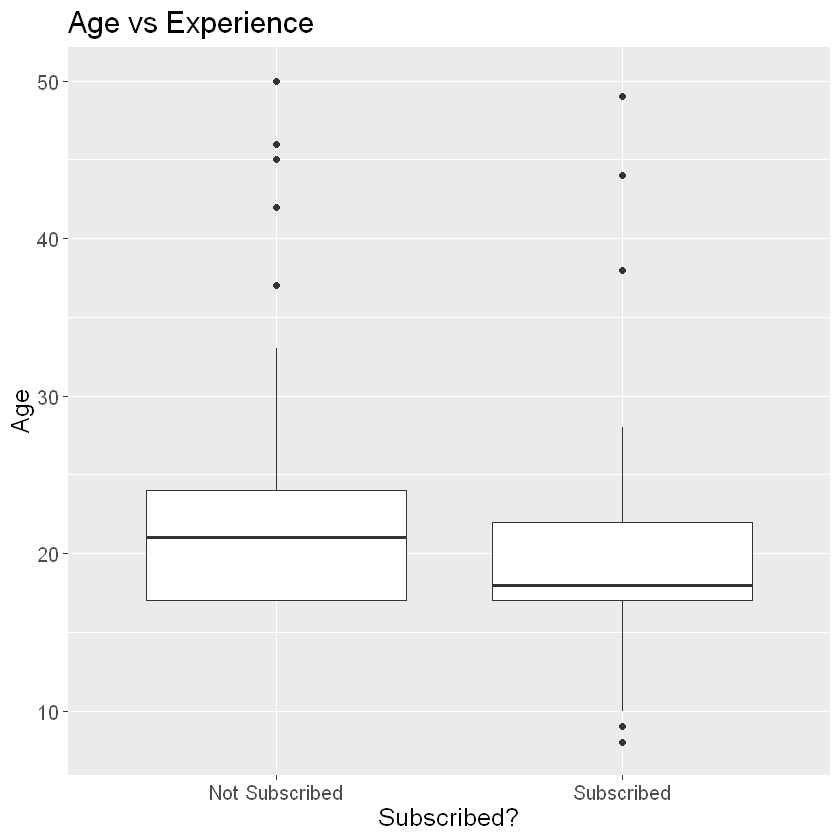

In [23]:
players_data |>
    select(subscribe, age) |>
    ggplot(aes(x = subscribe, y = age)) +
    geom_boxplot() +
    ggtitle("Age vs Experience") +
    xlab("Subscribed?") +
    ylab("Age") +
    scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
    theme(text = element_text(size = 15))


*Figure 16*

The plot appears to show non-subscribed players being older on average while younger players are more likely to be subscribed.

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 85 rows containing non-finite outside the scale range
(`stat_boxplot()`)."


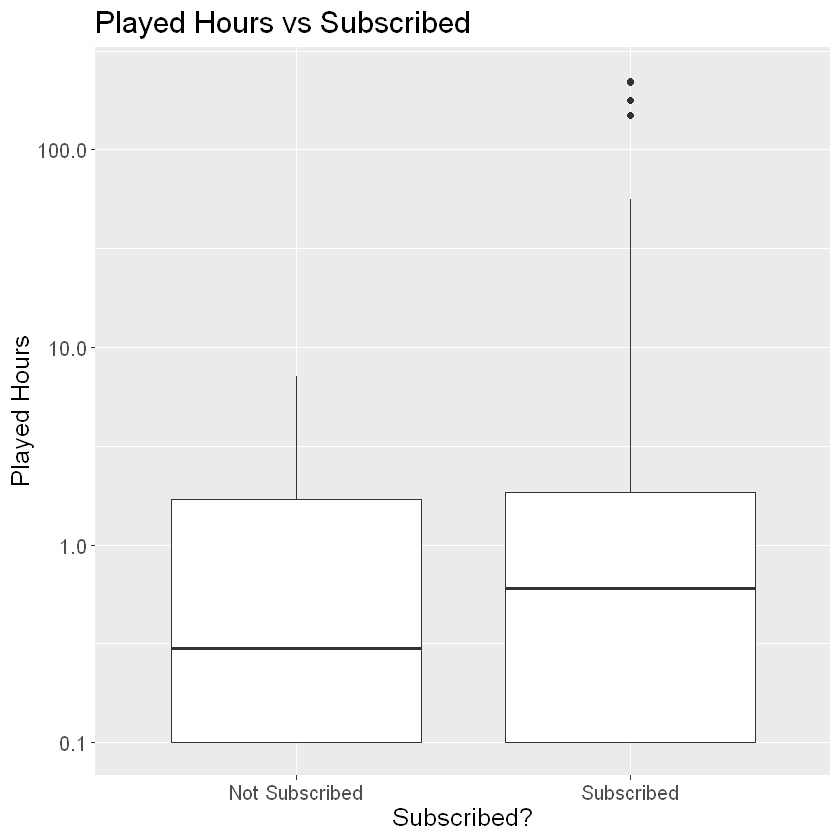

In [24]:
players_data |>
    select(subscribe, played_hours) |>
    ggplot(aes(x = subscribe, y = played_hours)) +
    geom_boxplot() +
    ggtitle("Played Hours vs Subscribed") +
    xlab("Subscribed?") +
    ylab("Played Hours") +
    scale_y_log10() +
    scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
    theme(text = element_text(size = 15))


*Figure 17*

This plot shows, while most points are concentrated near the bottom, all players with higher played hours are subscribed. 

*Note: the plot is in log10 scale*

`summarise()` has grouped output by 'subscribe'. You can override using the
`.groups` argument.


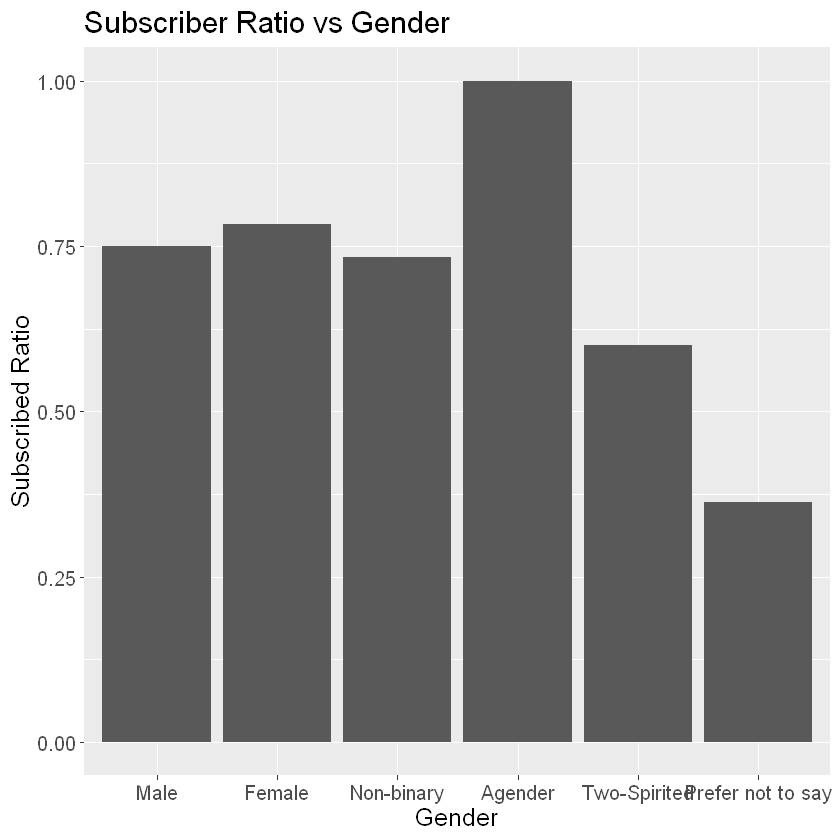

In [25]:
players_data |>
    group_by(subscribe, gender) |>
    summarize(count = n()) |>
    pivot_wider(names_from = subscribe, values_from = count, values_fill = list(count = 0)) |>
    mutate(sub_ratio = `TRUE` / (`TRUE` + `FALSE`), gender = factor(gender, levels = c("Male", "Female", "Non-binary", "Agender", "Two-Spirited", "Prefer not to say"))) |>
    select(gender, sub_ratio) |>
    ggplot(aes(x = gender, y = sub_ratio)) +
    geom_bar(stat = "identity") +
    ggtitle("Subscriber Ratio vs Gender") +
    xlab("Gender") +
    ylab("Subscribed Ratio") +
    scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
    theme(text = element_text(size = 15))


*Figure 18*

This graph shows agender people having the highest subscribed ratio, but again, if we reference Figure 8, we see that they represent only a small portion of the data and is likely biased.

## Classification Model for Subscribers

In [26]:
set.seed(0)
player_model_data <- players_data |>
    mutate(experience = as.integer(experience)) |>
    rep_sample_n(size = 194, replace = TRUE, reps = 10)

subscribers_split <- player_model_data |>
    initial_split(prop = 0.75)

subscribers_training <- training(subscribers_split)
subscribers_testing <- testing(subscribers_split)

subscribers_vfold <- vfold_cv(subscribers_training, v = 5, repeats = 5, strata = subscribe)

subscribers_k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_classification_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

subscribers_recipe <- recipe(subscribe ~ experience + played_hours + gender + age, data = subscribers_training) |>
    step_dummy(gender) |>
    step_smote(subscribe) |>
    step_zv() |>
    step_normalize(all_predictors())

subscribers_results <- workflow() |>
    add_recipe(subscribers_recipe) |>
    add_model(knn_classification_spec) |>
    tune_grid(resamples = subscribers_vfold, grid = subscribers_k_values) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

subscribers_results_plot <- subscribers_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs Neighbors") +
    xlab("Neighbors") +
    ylab("Accuracy")


In [27]:
player_model_data


replicate,experience,subscribe,hashed_email,played_hours,gender,age
<int>,<int>,<fct>,<chr>,<dbl>,<fct>,<int>
1,3,FALSE,a2a0612e9a7da558cbac2ee3c816740324505a69a6e042c94aa1b67731f9ff01,0.0,Male,18
1,2,TRUE,18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,17.2,Male,14
1,1,FALSE,42eafe96ed5c1684e3b5cc614d1b01a117173d3ec6898abcf1177d9822bd39f7,0.3,Female,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,2,FALSE,df6a1201c9c638aff1df8aeaf459a5b0a00aa04824936ee0305f5c275352c647,0.0,Prefer not to say,33
10,2,TRUE,22a78bfd44e46931261d06864b92cf9a8fd77fb02bec66cb71646dd9da222a0d,1.2,Non-binary,17
10,3,TRUE,657e5c2da9dad8ec67b8f2875d98c290dc97573d86b77022d3b58ee913ed491c,0.0,Male,20


*Figure 19*

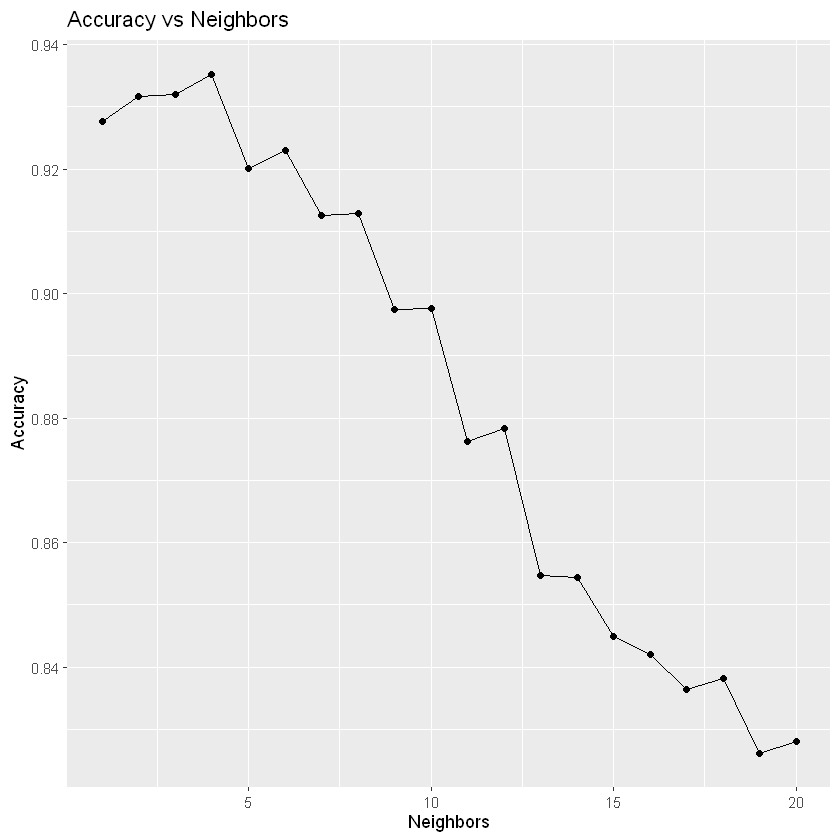

In [28]:
subscribers_results_plot


*Figure 20*

This model uses a KNN classification algorithm to predict the subscription status for each player given the players' experience, gender, age, and played hours. KNN is used because we do not know anything about the shape of the data. Classification is used because we are predicting a categorical outcome. The given data is still small for all the folds and splits. Bootlegging can be used again to create a more stable model that would give more useful results.

The dataset has been replicated 10 times and split into 0.75 ratio sets, and vfold repeats has been set to 5. Gender is one-hot encoded and subscribe is passed into step_smote which rebalances it's distribution in a more sophisticated way compared to upsample.

This produces a best-k-value of 4.

In [29]:
subscribers_best_k <- subscribers_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
cat("Best k-value: ", subscribers_best_k)

best_knn_classification_spec <- nearest_neighbor(weight = "rectangular", neighbors = subscribers_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

subscribers_fit <- workflow() |>
    add_recipe(subscribers_recipe) |>
    add_model(best_knn_classification_spec) |>
    fit(data = subscribers_training)


Best k-value:  4

In [30]:
subscribers_predictions <- predict(subscribers_fit, subscribers_testing) |>
    bind_cols(subscribers_testing)

subscribers_accuracy <- subscribers_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

subscribers_precision <- subscribers_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second") |>
    pull(.estimate)

subscribers_recall <- subscribers_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second") |>
    pull(.estimate)

subscribers_conf_mat <- subscribers_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

cat("Accuracy: ", subscribers_accuracy, "\n")
cat("Precision: ", subscribers_precision, "\n")
cat("Recall: ", subscribers_recall, "\n\n")
subscribers_conf_mat


Accuracy:  0.9092784 
Precision:  0.9617647 
Recall:  0.9134078 



          Truth
Prediction FALSE TRUE
     FALSE   114   31
     TRUE     13  327

The model reports a 90.9% accuracy, 96.2% precision, and 91.3% recall. This is quite high and does suggest that these predictors may be able to predict a player's subscription status.

## Discussion
DNF